# Identifying A Simple Rational Function Using SINDy Algorithm

Objectives:

1. Simulate the Michaelis-Menten kinetics model for an enzymatic reaction
2. Identify a nonlinear ODE from the data (using SINDy extension for rational function nonlinearities)
2. Test the model on additional data
3. See if noise affects the model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from sindy import polynomial_features, sparsify_dynamics_lstsq

import enzyme
from importlib import reload
reload(enzyme)

%matplotlib inline

In [2]:
data_dir = '../../data'
plot_dir = '../../plots'

### Generate Data by Simulating System

- The Michaelis-Menten kinetics model of enzymatic reactions

In [3]:
# Size of system
n = 1

# Simulation settings
dt = 0.1
T = 4
t = np.arange(dt, T + dt, dt)
T = len(t)

# Initial conditions
x0 = (0.5, 1)

# Simulate using scipy.integrate.odeint method
# Produces same results as Matlab
fun = enzyme.mmkinetics
rtol = 10e-12
atol = 10e-12 * np.ones_like(x0)
x_data = odeint(fun, x0, t, tfirst=True, rtol=rtol, atol=atol)
assert x_data.shape == (T, 2)

# Calculate derivatives
dxdt_data = fun(t, x_data)
assert dxdt_data.shape == (T, 2)

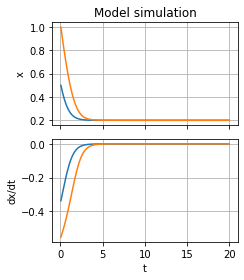

In [4]:
fig, axes = plt.subplots(2, 1, sharex=True,
                         figsize=(3.5, 4))

ax = axes[0]
ax.plot(t, x_data)
ax.set_ylabel('x')
ax.set_title('Model simulation')
ax.grid()

ax = axes[1]
ax.plot(t, dxdt_data)
ax.set_xlabel('t')
ax.set_ylabel('dx/dt')
ax.grid()

filepath = os.path.join(plot_dir, 'mm-kinetics-plot.pdf')
plt.tight_layout()
plt.savefig(filepath)
plt.show()

In [35]:
# Add noise & calculate derivative
eps = 1e-4  # noise magnitude 

# Normally distributed measuement error
xn_data = x_data + eps * np.random.randn(*x_data.shape)

In [37]:
x_data.shape, dxdt_data.shape, xn_data.shape

((400, 2), (400, 2), (400, 2))

In [6]:
#polynomial_features(x.T)

In [25]:
# Pick one trajectory
i = 0
x, dxdt = x_data[:, i], dxdt_data[:, i]
assert x.shape == (T,)
assert dxdt.shape == (T,)

theta_1 = polynomial_features(x)
assert theta_1.shape == (T, 4)

In [32]:
pd.DataFrame({'x': x, 'dxdt': dxdt}).head()

,x,dxdt
0,0.500000,-0.337500
1,0.483422,-0.325597
2,0.467441,-0.313636
3,0.452059,-0.301643
4,0.437277,-0.289646


In [27]:
theta_2 = theta_1 * dxdt.reshape(-1, 1)
theta_2.shape

(400, 4)

In [29]:
theta_1[:5, :]

array([[1.        , 0.5       , 0.25      , 0.125     ],
       [1.        , 0.48342228, 0.2336971 , 0.11297438],
       [1.        , 0.46744126, 0.21850133, 0.10213654],
       [1.        , 0.45205922, 0.20435753, 0.09238171],
       [1.        , 0.43727704, 0.19121121, 0.08361227]])

In [28]:
theta_2[:5, :]

array([[-0.3375    , -0.16875   , -0.084375  , -0.0421875 ],
       [-0.32559713, -0.15740091, -0.0760911 , -0.03678414],
       [-0.31363591, -0.14660636, -0.06852986, -0.03203369],
       [-0.30164286, -0.13636044, -0.06164299, -0.02786628],
       [-0.28964599, -0.12665554, -0.05538356, -0.02421796]])

In [34]:
theta = np.hstack([theta_1, theta_2])
theta.shape

(400, 8)

In [16]:
# Estimate sparse dynamic model
lamb = 0.025  # sparsification knob lambda
xi = sparsify_dynamics_lstsq(theta, dxdt, lamb, n)
assert xi.shape == (20, 3)

IndexError: too many indices for array